### Импорт зависимостей

In [ ]:
# !pip install rdkit catboost
# !python -m pip install git+https://github.com/EBjerrum/molvecgen

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import cross_val_score
from molvecgen.vectorizers import SmilesVectorizer

In [2]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA

In [37]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Предобработка

In [56]:
df = pd.read_excel('/content/drive/MyDrive/AtomicHack/Копия 35000.xlsx')
df.head()

,Unnamed: 0,Title,IC50,SMILES
0,NaN,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,NaN,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,NaN,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,NaN,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,NaN,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...


In [57]:
# Удаляем unnamed и REF
df = df.iloc[:, 1:]
df = df.loc[df['Title'] != '#REF!']
df = df.loc[df['SMILES'] != '#REF!']
df.describe()

,Title,IC50,SMILES
count,34909,34909.000,34909
unique,34909,9549.000,34887
top,CHEMBL2206459,3.224,CCCC[C@H](NC(=O)C)[C@@H]([C@@H](C1)N=C(N)N)C[C...
freq,1,30.000,3


In [58]:
duplicates_count = df.duplicated(subset='SMILES').sum()
print(duplicates_count)
df.drop_duplicates(subset='SMILES', inplace=True)

22


Попытка удаления дубликатов с помощью Finger Print.
В итоге дубликаты были выброшены ввиду большого размера датасета

In [59]:
def RDKfingerPrint(mol_smi, **kwargs):
    mol = Chem.MolFromSmiles(mol_smi)
    desc_vec = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(AllChem.RDKFingerprint(mol, **kwargs), desc_vec)
    return desc_vec

# Применить функцию RDKit FingerPrint ко всем строкам в столбце 'SMILES' и создать новые столбцы
df[['RDKFP_' + str(i) for i in range(2048)]] = df['SMILES'].apply(lambda x: pd.Series(RDKfingerPrint(x, maxPath=5)))
df.head()

[09:58:49] Conflicting single bond directions around double bond at index 7.
[09:58:49]   BondStereo set to STEREONONE and single bond directions set to NONE.


,Title,IC50,SMILES,RDKFP_0,RDKFP_1,RDKFP_2,RDKFP_3,RDKFP_4,RDKFP_5,RDKFP_6,...,RDKFP_2038,RDKFP_2039,RDKFP_2040,RDKFP_2041,RDKFP_2042,RDKFP_2043,RDKFP_2044,RDKFP_2045,RDKFP_2046,RDKFP_2047
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,1,1,1,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0


In [60]:
# Создаём Finger Prints, с помощью них находим дубликаты
# Итерируемся по дубликатам, рассчитываем расстояние
# Изменяем таблицу с дубликатами, дропаем все дубликаты, вставляем измененные дубликаты в общую таблицу
df['finger'] = df['SMILES'].apply(lambda x: AllChem.RDKFingerprint(Chem.MolFromSmiles(x)))
duplicates = df[df.duplicated(subset='Title', keep='first')]

for i in range(len(duplicates)):
  distances = []
  fps_1 = duplicates.iloc[i]['finger']
  for j in range(len(df)):
    fps_2 = df.iloc[j]['finger']
    if fps_1 != fps_2:
      dist = DataStructs.FingerprintSimilarity(fps_1, fps_2)
      distances.append(dist)
  duplicates.loc[duplicates.index[i], 'IC50'] = df.iloc[np.argmax(distances)]['IC50']
df.drop_duplicates(subset='Title', keep=False, inplace=True)
df = pd.concat([df, duplicates]).drop('finger', axis=1)

[10:00:26] Conflicting single bond directions around double bond at index 7.
[10:00:26]   BondStereo set to STEREONONE and single bond directions set to NONE.


(array([5.7670e+03, 2.4816e+04, 3.8960e+03, 2.5500e+02, 4.4000e+01,
        3.5000e+01, 3.3000e+01, 1.6000e+01, 2.3000e+01, 2.0000e+00]),
 array([  7. ,  34.4,  61.8,  89.2, 116.6, 144. , 171.4, 198.8, 226.2,
        253.6, 281. ]),
 <BarContainer object of 10 artists>)

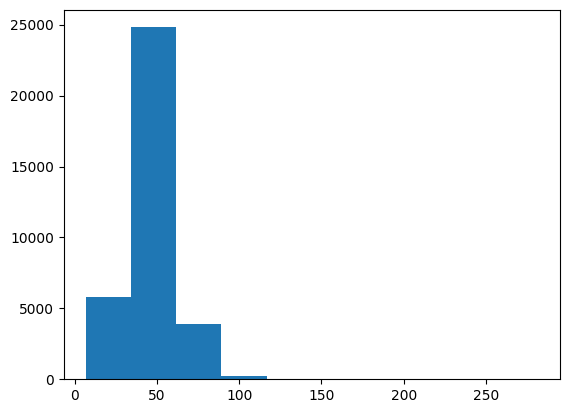

In [61]:
df['S_leng'] = df['SMILES'].str.len ()
plt.hist(df['S_leng'])

In [62]:
# Функция для удаления выбросов на основе IQR
def remove_outliers_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_filtered

(array([  43.,  571., 3373., 6053., 7826., 6693., 4396., 3101., 1410.,
         649.]),
 array([12. , 18.7, 25.4, 32.1, 38.8, 45.5, 52.2, 58.9, 65.6, 72.3, 79. ]),
 <BarContainer object of 10 artists>)

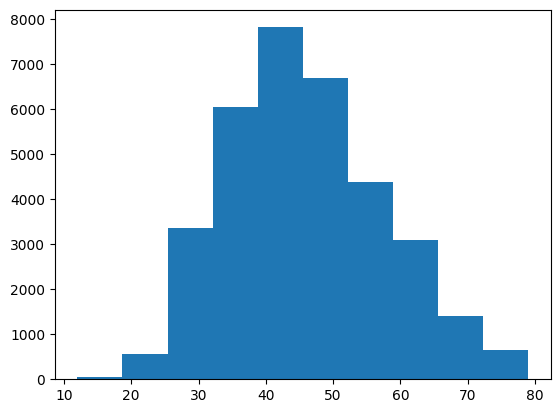

In [63]:
# Удаление выбросов в столбце 'S_leng' на основе IQR
df = remove_outliers_iqr(df, 'S_leng')
plt.hist(df['S_leng'])

### Воспользуемся дескрипторами

In [64]:
df_w = df[['SMILES']]
df_v = df[['IC50']]

In [66]:
PandasTools.AddMoleculeColumnToFrame(df_w,'SMILES','Molecule')
df_w[["SMILES","Molecule"]]

,SMILES,Molecule
0,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,<rdkit.Chem.rdchem.Mol object at 0x7fdb18c4eea0>
1,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,<rdkit.Chem.rdchem.Mol object at 0x7fdbc87f21f0>
2,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,<rdkit.Chem.rdchem.Mol object at 0x7fdbc87f2260>
3,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,<rdkit.Chem.rdchem.Mol object at 0x7fdbc87f2340>
4,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,<rdkit.Chem.rdchem.Mol object at 0x7fdbc87f23b0>
...,...,...
36369,CC(=O)Nc(cc1)c(O)cc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7fdbcb097060>
36371,CC(=O)Nc(c(c1)O)c(N)cc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7fdbcb0970d0>
36373,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7fdbcb097140>
36375,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7fdbcb0971b0>


In [67]:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(df_w.Molecule.values)

In [68]:
# Класс датасет для SMILES Descriptors
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        mols = self.molecules[idx]
        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        return sample, label

In [69]:
# Функция для RDKit Descriptors
def mol_dsc_calc(mols):
    return pd.DataFrame({k: f(Chem.MolFromSmiles(m)) for k, f in descriptors.items()} for m in mols)

# Cписок конституционных и физико-химических дескрипторов из библиотеки RDKit
descriptors = {"HeavyAtomCount": Descriptors.HeavyAtomCount,
               "NHOHCount": Descriptors.NHOHCount,
               "NOCount": Descriptors.NOCount,
               "NumHAcceptors": Descriptors.NumHAcceptors,
               "NumHDonors": Descriptors.NumHDonors,
               "NumHeteroatoms": Descriptors.NumHeteroatoms,
               "NumRotatableBonds": Descriptors.NumRotatableBonds,
               "NumValenceElectrons": Descriptors.NumValenceElectrons,
               "NumAromaticRings": Descriptors.NumAromaticRings,
               "NumAliphaticHeterocycles": Descriptors.NumAliphaticHeterocycles,
               "RingCount": Descriptors.RingCount,
               "MW": Descriptors.MolWt,
               "LogP": Descriptors.MolLogP,
               "MR": Descriptors.MolMR,
               "TPSA": Descriptors.TPSA}

In [70]:
# Функция для RDKit Finger Print
def RDKfingerPrint(mol_smi, **kwargs):
    mol = Chem.MolFromSmiles(mol_smi)
    desc_vec = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(AllChem.RDKFingerprint(mol, **kwargs), desc_vec)
    return desc_vec

In [71]:
# Делим датафрейм на признаки и таргет
y = df_v['IC50'].values.reshape((-1,1))
X = df_w.Molecule.values
train_dataset = SMILESMolDataset(X, y, smivec)
df = df.reset_index(drop = True)
result_df = df

vectorizers = ['smiles', 'rdkitDescriptors'] # on 'rdkitFP', 'rdkitDescriptors'
if 'smiles' in vectorizers:
    new_dataset = []

    for item in train_dataset:
        flattened_item = item[0][0].flatten()
        new_dataset.append([*flattened_item])
    smiles = pd.DataFrame(new_dataset)

    # Добавим
    result_df = pd.concat([result_df, smiles], axis=1)

if 'rdkitDescriptors' in vectorizers:
    # Sklearn трансформер для использования в конвейерном моделировании
    descriptors_transformer = FunctionTransformer(mol_dsc_calc)
    X_descr = descriptors_transformer.transform(df['SMILES'])

    # Добавим
    result_df = pd.concat([result_df, X_descr], axis=1)

if 'rdkitFP' in vectorizers:
    # Применить функцию RDKfingerPrint ко всем строкам в столбце 'SMILES' и создать новые столбцы
    df[['RDKFP_' + str(i) for i in range(2048)]] = df['SMILES'].apply(lambda x: pd.Series(RDKfingerPrint(x, maxPath=5)))

    # Добавим
    result_df = pd.concat([result_df, df], axis=1)

In [73]:
result_df = result_df.drop(columns = ['IC50','Title', 'SMILES'])
result_df.head()

,RDKFP_0,RDKFP_1,RDKFP_2,RDKFP_3,RDKFP_4,RDKFP_5,RDKFP_6,RDKFP_7,RDKFP_8,RDKFP_9,...,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,MW,LogP,MR,TPSA
0,0,1,0,0,0,0,0,0,0,0,...,10,7,138,0,0,1,362.367,0.38187,90.4296,157.76
1,0,0,0,0,0,0,0,0,1,0,...,6,7,120,0,0,1,298.383,1.05450,79.7279,101.65
2,0,0,1,0,0,0,0,0,1,0,...,6,7,118,0,0,1,295.359,-0.36170,77.0531,104.48
3,0,0,0,0,0,0,0,0,1,0,...,6,6,114,0,0,1,283.348,-0.52780,72.5301,104.48
4,1,1,1,0,0,1,0,0,0,0,...,9,3,122,3,0,3,329.268,1.09742,81.9775,149.28


In [74]:
# Стандартизация y
scaler = StandardScaler()
y = scaler.fit_transform(y)

In [76]:
# Функция для попарного перемножения признаков
def add_feature_interactions(df, features):
    # Создаем копию датафрейма, чтобы не изменять оригинал
    result_df = df.copy()
    # features = df.columns # Раскомментировать, если нужно перемножить все признаки

    for i in range(len(features)):
        for j in range(i+1, len(features)):
            feature1 = features[i]
            feature2 = features[j]
            new_feature_name = f"{feature1}_{feature2}_interaction"
            result_df[new_feature_name] = df[feature1] * df[feature2]

    return result_df

features = [
    'HeavyAtomCount', 'NHOHCount', 'NOCount',
    'NumHAcceptors', 'NumHDonors'
]

# result_df = add_feature_interactions(result_df, features)
result_df.head()

,RDKFP_0,RDKFP_1,RDKFP_2,RDKFP_3,RDKFP_4,RDKFP_5,RDKFP_6,RDKFP_7,RDKFP_8,RDKFP_9,...,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,MW,LogP,MR,TPSA
0,0,1,0,0,0,0,0,0,0,0,...,10,7,138,0,0,1,362.367,0.38187,90.4296,157.76
1,0,0,0,0,0,0,0,0,1,0,...,6,7,120,0,0,1,298.383,1.05450,79.7279,101.65
2,0,0,1,0,0,0,0,0,1,0,...,6,7,118,0,0,1,295.359,-0.36170,77.0531,104.48
3,0,0,0,0,0,0,0,0,1,0,...,6,6,114,0,0,1,283.348,-0.52780,72.5301,104.48
4,1,1,1,0,0,1,0,0,0,0,...,9,3,122,3,0,3,329.268,1.09742,81.9775,149.28


In [80]:
result_df.describe()

,RDKFP_0,RDKFP_1,RDKFP_2,RDKFP_3,RDKFP_4,RDKFP_5,RDKFP_6,RDKFP_7,RDKFP_8,RDKFP_9,...,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,MW,LogP,MR,TPSA
count,34115.000000,34115.000000,34115.000000,34115.000000,34115.000000,34115.000000,34115.000000,34115.000000,34115.000000,34115.000000,...,34115.000000,34115.000000,34115.000000,34115.000000,34115.000000,34115.000000,34115.000000,34115.000000,34115.000000,34115.000000
mean,0.523406,0.246871,0.344687,0.173267,0.099927,0.570775,0.084831,0.072021,0.147384,0.042064,...,6.521149,4.608120,128.053759,2.458186,0.492305,3.119537,353.249002,3.338321,95.539061,69.997097
std,0.499459,0.431197,0.475273,0.378483,0.299907,0.494973,0.278634,0.258527,0.354493,0.200737,...,2.142868,2.196841,28.052665,0.974150,0.660947,1.029160,75.531415,1.223169,20.236238,27.109982
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,38.000000,0.000000,0.000000,0.000000,112.084000,-4.960300,21.941500,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,3.000000,108.000000,2.000000,0.000000,2.000000,297.402000,2.663700,80.839500,50.700000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,4.000000,126.000000,2.000000,0.000000,3.000000,347.400000,3.402380,93.841500,67.490000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,8.000000,6.000000,148.000000,3.000000,1.000000,4.000000,406.352000,4.105520,109.466900,86.480000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,27.000000,238.000000,7.000000,5.000000,8.000000,833.879000,9.322600,187.228400,223.070000


### Обучение регрессора

In [81]:
cat_model = CatBoostRegressor(verbose = 500)

In [82]:
scores = cross_val_score(cat_model, result_df, y, cv=5, scoring='neg_root_mean_squared_error')
scores.mean()

Learning rate set to 0.069036
0:	learn: 1.0989952	total: 332ms	remaining: 5m 32s
500:	learn: 0.2396934	total: 1m 32s	remaining: 1m 31s
999:	learn: 0.1481710	total: 2m 52s	remaining: 0us
Learning rate set to 0.069036
0:	learn: 1.1122682	total: 136ms	remaining: 2m 15s
500:	learn: 0.2468998	total: 1m 18s	remaining: 1m 18s
999:	learn: 0.1530579	total: 2m 38s	remaining: 0us
Learning rate set to 0.069036
0:	learn: 1.1040495	total: 143ms	remaining: 2m 22s
500:	learn: 0.2629976	total: 1m 17s	remaining: 1m 17s
999:	learn: 0.1708792	total: 2m 36s	remaining: 0us
Learning rate set to 0.069036
0:	learn: 1.1051365	total: 257ms	remaining: 4m 17s
500:	learn: 0.2478891	total: 1m 18s	remaining: 1m 18s
999:	learn: 0.1639947	total: 2m 36s	remaining: 0us
Learning rate set to 0.069036
0:	learn: 0.0439851	total: 260ms	remaining: 4m 19s
500:	learn: 0.0366818	total: 1m 20s	remaining: 1m 20s
999:	learn: 0.0335635	total: 2m 39s	remaining: 0us


-0.7985377364506028

In [83]:
# Видим замисимость от folds, необходимо сделать shuffle
scores

array([-0.81430373, -0.51815265, -0.16676731, -0.25295891, -2.24050608])

In [84]:
cat_model.fit(result_df, y)

Learning rate set to 0.071513
0:	learn: 0.9850677	total: 272ms	remaining: 4m 31s
500:	learn: 0.2422259	total: 1m 23s	remaining: 1m 23s
999:	learn: 0.1540889	total: 2m 45s	remaining: 0us


In [85]:
# Сохраним модель для использования на датасете с 1400 примерами
cat_model.save_model('weights.bin')

In [86]:
# Можно оптимизировать датасет на основании важности признаков
cat_model.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 2.25958559e-03, ...,
       1.38184511e+01, 5.11234491e+00, 1.63417607e+00])